# PCA-based Image Compression on the MNIST Dataset

## Introduction
Principal component analysis (PCA) is a dimensinoality reduction technique that finds a new coordinate system for the data such that the maximized variance by some projection of the data comes to lie on the first coordinate (the first principal component), the second maximized variance on the second coordinate, and so forth. In this final project, we will use PCA to compress images from the MNIST dataset of handwritten digits. We will investigate how many components are needed to retain most of the variance in the data, and compare the reconstructed images to the originals.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from tensorflow.keras.datasets import mnist

# Load MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


## The MNIST Dataset

The MNIST dataset is a common dataset of handwritten digits. Each sample is a 28x28 grayscale image and there are 10 possible classes (0 through 9). The training set contains 60,000 images and the test set contains 10,000 images.

In [3]:
# Print shapes of the data
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

print('Number of training samples:', x_train.shape[0])
print('Number of test samples:', x_test.shape[0])

x_train shape: (60000, 28, 28)
y_train shape: (60000,)
x_test shape: (10000, 28, 28)
y_test shape: (10000,)
Number of training samples: 60000
Number of test samples: 10000


From the above cell, we see that:
- `x_train` contains 60,000 images, each of size 28×28.
- `y_train` contains 60,000 labels corresponding to those images.
- `x_test` contains 10,000 images, again each of size 28×28.
- `y_test` contains 10,000 labels.

We'll use the training set to learn the principal components and later evaluate reconstruction quality using both the training and test sets.

## Data Exploration

In this section, we will explore the MNIST data. First, let's visualize a few images from our training set to see what the handwritten digits look like. We will also look at a distribution of pixel intensities for a single image to understand how the pixel values are spread out.

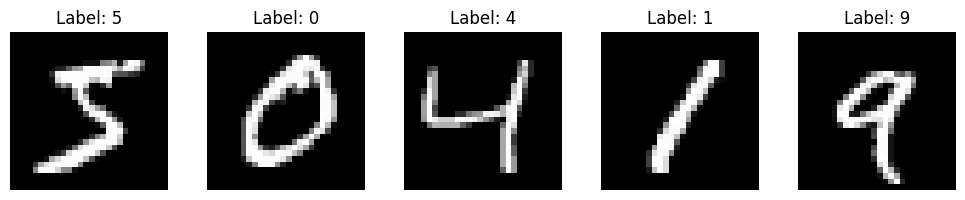

In [5]:
plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f'Label: {y_train[i]}')
    plt.axis('off')
plt.tight_layout()

From the figures, we can see that each image is a 28×28 grayscale digit. Our goal will be to reduce the dimensionality of these images using PCA, while trying to preserve as much information as possible.

## Preprocessing

Before applying PCA, we need to flatten our 28×28 images into 784-dimensional vectors, and normalize the pixel values.

Flattening the images will allow PCA to interpret each image as a single row in our data matrix. Normalizing helps ensure that all pixels contribute equally to the variance, especially if we decide to use any distance-based measure.

In [8]:
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

print("Before normalization:")
print("x_train_flat shape:", x_train_flat.shape)
print("x_test_flat shape:", x_test_flat.shape)

x_train_flat = x_train_flat.astype('float32')
x_test_flat = x_test_flat.astype('float32')

x_train_flat /= 255.0
x_test_flat /= 255.0

print("After normalization, min and max pixel value in x_train_flat:",
      x_train_flat.min(), x_train_flat.max())

Before normalization:
x_train_flat shape: (60000, 784)
x_test_flat shape: (10000, 784)
After normalization, min and max pixel value in x_train_flat: 0.0 1.0


## Applying PCA

Now that our data is preprocessed (flattened and optionally normalized), we can apply PCA. PCA will find the directions in the data that explain the most variance.

**Steps**:
1. Choose the number of principal components, `n_components`.
2. Fit the PCA model on the training data.
3. Transform the original data to the PCA space (lower-dimensional).
4. Reconstruct the images by transforming back to the original space.

In [27]:
from sklearn.decomposition import PCA

# Let's pick a number of components. We can start with 100 as an example.
n_components = 100
pca = PCA(n_components=n_components)

# Fit PCA on the training data
pca.fit(x_train_flat)

# Transform the training and test sets
x_train_pca = pca.transform(x_train_flat)
x_test_pca = pca.transform(x_test_flat)

print("Original dimensionality:", x_train_flat.shape[1])
print("Reduced dimensionality:", x_train_pca.shape[1])

Original dimensionality: 784
Reduced dimensionality: 100


Now, we will see how much variance is captured by the chosen principal components. The `explained_variance_ratio_` attribute of the PCA object tells us the fraction of the total variance in the dataset that each principal component captures. 

We can also look at the cumulative variance explained by the components to decide if 100 components is a good choice.

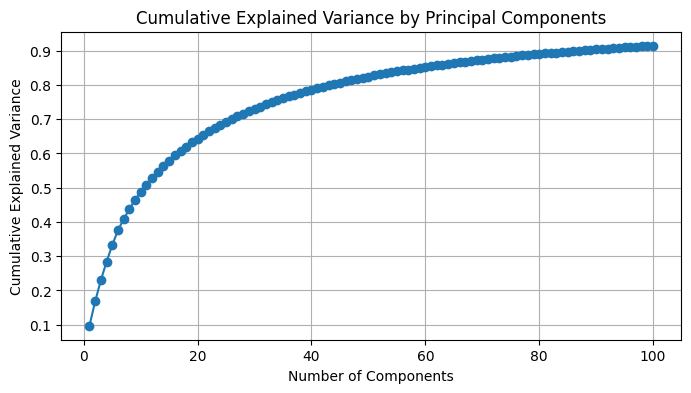

Variance retained with 100 components: 0.91


In [28]:
explained_variances = pca.explained_variance_ratio_
cumulative_variances = np.cumsum(explained_variances)

plt.figure(figsize=(8, 4))
plt.plot(range(1, n_components+1), cumulative_variances, marker='o')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

print(f"Variance retained with {n_components} components: {cumulative_variances[-1]:.2f}")

## Image Reconstruction

Using the principal components, we can also reconstruct the images by transforming the lower-dimensional representation back to the original space. Let's compare a few original images with their reconstructed versions to see how much detail is retained.

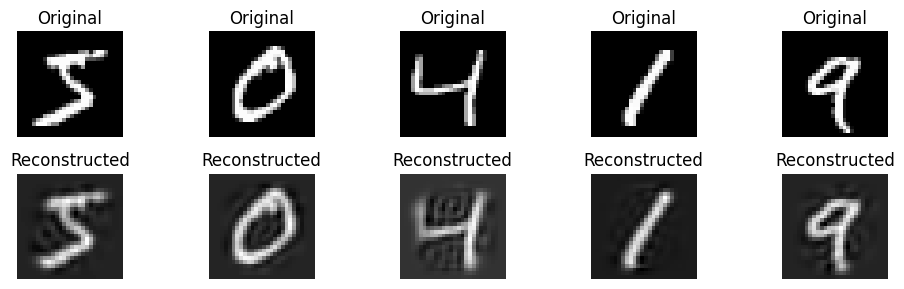

In [29]:
x_train_reconstructed = pca.inverse_transform(x_train_pca)

num_images_to_show = 5
plt.figure(figsize=(10, 3))

for i in range(num_images_to_show):
    plt.subplot(2, num_images_to_show, i+1)
    plt.imshow(x_train_flat[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')
    
    plt.subplot(2, num_images_to_show, i + 1 + num_images_to_show)
    plt.imshow(x_train_reconstructed[i].reshape(28, 28), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.tight_layout()
plt.show()

We can see that the reconstructed images capture the general shape of the digits, but some finer details may be lost. This loss typically becomes more pronounced as we reduce the number of principal components. 

On the other hand, using fewer components means we are using fewer numbers to represent each image, effectively compressing them. So there is a trade-off between the compression ratio and the reconstruction quality.

## Discussion and Conclusion

In this project, we applied PCA for image compression on the MNIST dataset. We:
- Flattened and normalized the images,
- Used PCA to reduce dimensionality from 784 to fewer components,
- Reconstructed images to evaluate compression quality.

**Key Observations**:
- Increasing the number of principal components improves reconstruction quality but lowers compression (higher dimensional representation).
- With fewer components, we gain more compression at the cost of blurry or distorted reconstructions.

## Links
Github: https://github.com/JeffreyLind3/CSCA5632